In [1]:
import pandas as pd
import re
from functools import partial
from collections import Counter
import string
import copy

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, TweetTokenizer
import spacy
import contractions

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

## It's important to use _lg for OOV in future
nlp = spacy.load('en_core_web_lg')
STOPWORDS = set(stopwords.words('english'))
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/tsm_label_data.csv',encoding="Latin-1")

In [3]:
df.shape

(131, 6)

In [4]:
df.head()

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1)
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/07/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/07/2023,https://tsmliberia.com/correct-costa-got-8-per...,1
2,What Did Representative Foko Say about Weahâ...,Mark Mengonfia,There have been a variety of responses to a st...,08/07/2023,https://tsmliberia.com/what-did-representative...,1
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1


In [5]:
# remove extra spaces
df['content'] = df['content'].str.replace("  ", " ")

## Extract labels

In [6]:
# find substring verdict: true OR verdict: partly true OR verdict: scum
# return 1 if substring exists, otherwise - 0
def find_verdict_true(text):   
    verd_true = re.search('verdict: (true|.*partly true|scum)', text, re.IGNORECASE)
    if verd_true:
        return 1
    else:
        return 0

In [7]:
# find substring verdict: false OR verdict: fake true OR verdict: no OR verdict: incorrect OR verdict: misleading OR verdict: untrue
# return 1 if substring exists, otherwise - 0
def find_verdict_false(text):   
    verd_true = re.search('verdict: (false|fake|no|incorrect|misleading|untrue)', text, re.IGNORECASE)
    if verd_true:
        return 1
    else:
        return 0

In [8]:
df['verdict_true'] = df.content.apply(find_verdict_true)
df['verdict_false'] = df.content.apply(find_verdict_false)

In [9]:
# check labels
# shows if in the text the verdict was false, but the hand label is true
df[(df.verdict_false == 1) & (df['Label (Fake-0| True-1)'] == 1)]

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),verdict_true,verdict_false
76,"No, Ex-President Ellen Johnson Sirleaf is not ...",The Stage Media-Liberia,Claim: Ex- Liberian President Ellen Johnson Si...,06/12/2022,https://tsmliberia.com/no-ex-president-ellen-j...,1,0,1
77,False; Veralyn Vonleh is not The First Miss Li...,The Stage Media-Liberia,Post by the Liberian InfluenceBy: Joyclyn [ema...,06/12/2022,https://tsmliberia.com/false-veralyn-vonleh-is...,1,0,1
89,Fact Check:Â Nathaniel McGill Does Not Have Ac...,Bettie Johnson-Mbayo,Claim: UBA Ghana Reportedly Blocked Nathaniel ...,19/08/2022,https://tsmliberia.com/fact-check-nathaniel-mc...,1,0,1
117,"False, Immigration Officer head Was Not Cut Off",The Stage Media-Liberia,"Claim: Female Immigration officer, Maude Ellio...",02/11/2021,https://tsmliberia.com/false-immigration-offic...,1,0,1
123,"Fact Check -False, The UN did Not Issue this A...",The Stage Media-Liberia,Claim: UN issued an alert on the black market ...,27/09/2021,https://tsmliberia.com/fact-check-false-the-un...,1,0,1
126,Did 82 Percent of Liberians Agree to Transitio...,The Stage Media-Liberia,Pic Credit: FPAClaim: â82.2 percent of the L...,09/09/2021,https://tsmliberia.com/did-82-percent-of-liber...,1,0,1
128,Scam Alert: Coca Cola is not Running a Survey,The Stage Media-Liberia,social media user alertClaim: A survey about a...,07/09/2021,https://tsmliberia.com/scam-alert-coca-cola-is...,1,0,1


In [10]:
# relabeling
df.loc[(df.verdict_false == 1) & (df['Label (Fake-0| True-1)'] == 1), 'Label (Fake-0| True-1)'] = 0

In [11]:
# check labels
# shows if in the text the verdict was true, but the hand label is false
df[(df.verdict_true == 1) & (df['Label (Fake-0| True-1)'] == 0)]

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),verdict_true,verdict_false
10,"No, Srimex was not shut down due to tax Evasio...",Maima Wright,Claim: Liberia Revenue Authority Shuts down Mu...,17/06/2023,https://tsmliberia.com/no-srimex-was-not-shut-...,0,1,0
27,News of Bassaâs Superintendent Illness is Tr...,Maima Wright,"Claim: Grand Bassa County Superintendent, Janj...",16/05/2023,https://tsmliberia.com/news-of-bassas-superint...,0,1,0
67,Fact-Check:Â Is VP Taylor Correct On Census Cl...,Mark Mengonfia,Claim: This is Liberiaâs and West Africaâs...,19/01/2023,https://tsmliberia.com/fact-check-is-vp-taylor...,0,1,0


In [12]:
# relabeling
df.loc[(df.verdict_true == 1) & (df['Label (Fake-0| True-1)'] == 0), 'Label (Fake-0| True-1)'] = 1

### Split text

In [13]:
# searching in the text substring "Conclusion:" and separating the text into two parts
def find_text_conclusion(text):   
    return re.split("conclusion:", text, flags=re.IGNORECASE)[:2]

In [14]:
conclusion = df.content.apply(find_text_conclusion)
df_conclusion = pd.DataFrame.from_records(conclusion, columns=['before', 'after'])

In [15]:
df_conclusion.head()

,before,after
0,Claim: Sierra Leone was voted as a non-permane...,Unity Party Campaign Spokesmanâs claim that...
1,"Claim: Henry Costa only got 3,287 votes which ...",Correct. The claim by Kollie that Costa obtai...
2,There have been a variety of responses to a st...,CDC Lawmaker Foko indeed said those words; bu...
3,Claim: Henry Costa to contest the 2023 preside...,Henry Costa and RiverGee senator Jonathan Boy...
4,We have done a round of fact-checks in Liberia...,None


In [16]:
df['text_before_conclusion'] = df_conclusion['before']

In [17]:
# Deletes from text some regular patterns that don't relate to the text itself
# Removed patterns:
# Claim:
# Full text:
# Verdict: True
# Verdict: False
df.text_before_conclusion = df.text_before_conclusion.replace(
    '(?i)claim:|full text:|verdict: true|verdict: false', '', regex=True)

In [18]:
df.head()

,TITLE,publisher_name,content,publication_date,link,Label (Fake-0| True-1),verdict_true,verdict_false,text_before_conclusion
0,True! Sierra Leone was elected as a non-perman...,Gloria Wleh,Claim: Sierra Leone was voted as a non-permane...,11/07/2023,https://tsmliberia.com/true-sierra-leone-was-e...,1,1,0,Sierra Leone was voted as a non-permanent mem...
1,"Correct, Costa Got 8 Percent In 2017 Elections",R. Joyclyn Wea,"Claim: Henry Costa only got 3,287 votes which ...",11/07/2023,https://tsmliberia.com/correct-costa-got-8-per...,1,1,0,"Henry Costa only got 3,287 votes which consti..."
2,What Did Representative Foko Say about Weahâ...,Mark Mengonfia,There have been a variety of responses to a st...,08/07/2023,https://tsmliberia.com/what-did-representative...,1,0,0,There have been a variety of responses to a st...
3,The Post of Costa For President is Misleading,Mark Mengonfia,Claim: Henry Costa to contest the 2023 preside...,30/06/2023,https://tsmliberia.com/the-post-of-costa-for-p...,0,0,0,Henry Costa to contest the 2023 presidential ...
4,June Pidgin Edition,The Stage Media-Liberia,We have done a round of fact-checks in Liberia...,28/06/2023,https://tsmliberia.com/june-pidgin-edition/,1,0,0,We have done a round of fact-checks in Liberia...


### Feature Engineering

In [19]:
# count number of characters 
def count_chars(text):
    return len(text)

# count number of words 
def count_words(text):
    return len(text.split())

# count number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

# count number of capital words
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

# count number of punctuations
def count_punctuations(text):
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    return count(text,set(string.punctuation))
    
# count number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

# count number of unique words 
def count_unique_words(text):
    return len(set(text.split()))
    
# count of hashtags
def count_htags(text):
    x = re.findall(r'(\#\w[A-Za-z0-9]*)', text)
    return len(x)

# count of stopwords
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

#count of links
def count_links(text):
    link_list = re.findall(r'(https?://[^\s]+)', text)
    bitly_list = re.findall(r'bit.ly/\S+', text)
    return (len(link_list + bitly_list))

#count digits
def count_digits(text):
    digit_list = re.findall(r'[0-9]+', text)
    return len(digit_list)

# Factorize repeated punctuation, add REPEAT
def count_repeat_punct(text):
    rep_list = re.findall(r'([!?.]){2,}', text)
    return len(rep_list)

def punct_add_exclamation(text):
    return len(re.findall("!", text))

def punct_add_question(text):
    return len(re.findall("\?", text))

def punct_add_quotation(text):
    return len(re.findall("'", text))
    
# Write a function to display basic entity info:
def list_of_ents(doc, label = 'GPE'):
    doc = nlp(doc)
    list_gpe = []
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == label:
                #print(ent.text+' - '+ent.label_+' - '+str(spacy.explain(ent.label_)))
                list_gpe.append(ent.text)
    return list_gpe

def noun_counter(x):
    #tagged = nltk.pos_tag(x)
    noun_count = sum(1 for word, pos in nltk.pos_tag(word_tokenize(x)) if pos.startswith('NN'))
    return noun_count

def adj_counter(x):
    #tagged = nltk.pos_tag(x)
    adj_count = sum(1 for word, pos in nltk.pos_tag(word_tokenize(x)) if pos.startswith('JJ'))
    return adj_count

def verb_counter(x):
    #tagged = nltk.pos_tag(x)
    verb_count = sum(1 for word, pos in nltk.pos_tag(word_tokenize(x)) if pos.startswith('VB'))
    return verb_count

In [20]:
def feature_eng_fun(df_in, text):
    df = copy.deepcopy(df_in)
    df['count_num_of_chars'] = df[text].apply(count_chars)
    df['count_num_of_words'] = df[text].apply(count_words)
    df['count_unique_words'] = df[text].apply(count_unique_words)
    df['count_sent'] = df[text].apply(count_sent)
    df['count_num_of_capital_chars'] = df[text].apply(count_capital_chars)
    df['count_num_of_capital_words'] = df[text].apply(count_capital_words)
    df['count_stopwords'] = df[text].apply(count_stopwords)
    df['count_punct'] = df[text].apply(count_punctuations)
    df['count_exclamation'] = df[text].apply(punct_add_exclamation)
    df['count_question'] = df[text].apply(punct_add_question)
    df['count_quotation'] = df[text].apply(punct_add_quotation)
    df['count_htags'] = df[text].apply(count_htags)
    df['count_links'] = df[text].apply(count_links) 
    df['count_repeat_punct'] = df[text].apply(count_repeat_punct)    
    ## This function from part above
    df['GPE'] = df[text].apply(partial(list_of_ents, label='GPE'))
    df['count_GPE'] = df['GPE'].str.len()
    df['noun_count'] = df[text].apply(noun_counter)
    df['verb_count'] = df[text].apply(verb_counter)
    df['adj_count'] = df[text].apply(adj_counter)
    ## calculate frequency
    df['unique_word_frequency'] = 100*df['count_unique_words']/df['count_num_of_words']
    df['sent_length'] = 100*df['count_sent']/df['count_num_of_words']
    df['stopwords_frequency'] = 100*df['count_stopwords']/df['count_num_of_words']   
    df['punct_frequency'] = 100*df['count_punct']/df['count_num_of_words']   
    df['exclamation_frequency'] = 100*df['count_exclamation']/df['count_num_of_words']
    df['question_frequency'] = 100*df['count_question']/df['count_num_of_words']
    df['quotation_frequency'] = 100*df['count_quotation']/df['count_num_of_words']
    df['GPE_frequency'] = 100*df['count_GPE']/df['count_num_of_words']
    df['noun_frequency'] = 100*df['noun_count']/df['count_num_of_words']
    df['verb_frequency'] = 100*df['verb_count']/df['count_num_of_words']
    df['adj_frequency'] = 100*df['adj_count']/df['count_num_of_words']
    
    return df

In [21]:
## .loc will create a new copy, not view
df_feature_eng = df.loc[:, ('text_before_conclusion', 'Label (Fake-0| True-1)')]

In [22]:
df_feature_eng = feature_eng_fun(df_feature_eng, 'text_before_conclusion')

In [23]:
df_feature_eng

,text_before_conclusion,Label (Fake-0| True-1),count_num_of_chars,count_num_of_words,count_unique_words,count_sent,count_num_of_capital_chars,count_num_of_capital_words,count_stopwords,count_punct,count_exclamation,count_question,count_quotation,count_htags,count_links,count_repeat_punct,GPE,count_GPE,noun_count,verb_count,adj_count,unique_word_frequency,sent_length,stopwords_frequency,punct_frequency,exclamation_frequency,question_frequency,quotation_frequency,GPE_frequency,noun_frequency,verb_frequency,adj_frequency
0,Sierra Leone was voted as a non-permanent mem...,1,3432,548,284,7,163,15,210,86,1,4,0,0,0,1,"[Liberia, Liberia, Liberia, Algeria, Guyana, R...",14,210,84,32,51.824818,1.277372,38.321168,15.693431,0.182482,0.729927,0.0,2.554745,38.321168,15.328467,5.839416
1,"Henry Costa only got 3,287 votes which consti...",1,2113,332,218,13,107,12,109,62,0,3,0,0,0,0,"[Costaâs, Montserrado County]",2,133,45,24,65.662651,3.915663,32.831325,18.674699,0.000000,0.903614,0.0,0.602410,40.060241,13.554217,7.228916
2,There have been a variety of responses to a st...,1,1129,178,116,3,52,1,67,31,0,1,0,1,0,0,"[Montserrado County, Montserrado County]",2,61,35,9,65.168539,1.685393,37.640449,17.415730,0.000000,0.561798,0.0,1.123596,34.269663,19.662921,5.056180
3,Henry Costa to contest the 2023 presidential ...,0,1423,226,145,4,76,8,84,34,0,1,0,0,0,0,[Costa],1,86,39,16,64.159292,1.769912,37.168142,15.044248,0.000000,0.442478,0.0,0.442478,38.053097,17.256637,7.079646
4,We have done a round of fact-checks in Liberia...,1,119,25,24,2,3,0,8,4,0,0,0,0,0,0,[],0,4,6,2,96.000000,8.000000,32.000000,16.000000,0.000000,0.000000,0.0,0.000000,16.000000,24.000000,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Pic Credit: FPA â82.2 percent of the Liberia...,0,3375,511,252,3,129,12,207,62,0,0,0,0,0,0,"[Liberia, Liberia, Liberia, justice.âThe, Li...",6,197,81,37,49.315068,0.587084,40.508806,12.133072,0.000000,0.000000,0.0,1.174168,38.551859,15.851272,7.240705
127,Facebook(social Media) A Facebook page purport...,1,1880,312,173,13,63,2,140,42,2,0,0,2,0,1,"[Montserrado County, Liberia, Kolubah]",3,111,61,15,55.448718,4.166667,44.871795,13.461538,0.641026,0.000000,0.0,0.961538,35.576923,19.551282,4.807692
128,social media user alert A survey about a Coca-...,0,1340,220,149,7,44,2,98,38,4,0,0,0,0,0,"[accounts.âThe, Philippines]",2,71,49,12,67.727273,3.181818,44.545455,17.272727,1.818182,0.000000,0.0,0.909091,32.272727,22.272727,5.454545
129,social media A most recent circulating Faceboo...,1,2509,432,265,17,70,7,180,45,0,1,0,0,0,0,"[Nimba County, Monrovia, Liberia, Sanniquellie]",4,136,76,29,61.342593,3.935185,41.666667,10.416667,0.000000,0.231481,0.0,0.925926,31.481481,17.592593,6.712963


In [24]:
box_plot_columns = ['count_num_of_chars', 'count_num_of_words', 'count_unique_words', 
                    'count_sent', 'count_num_of_capital_chars', 'count_num_of_capital_words', 
                    'count_stopwords', 'count_GPE', 'unique_word_frequency', 'sent_length',
                    'stopwords_frequency', 'punct_frequency', 'exclamation_frequency', 
                    'question_frequency', 'quotation_frequency', 'GPE_frequency', 'noun_frequency',
                    'verb_frequency', 'adj_frequency'
                   ]

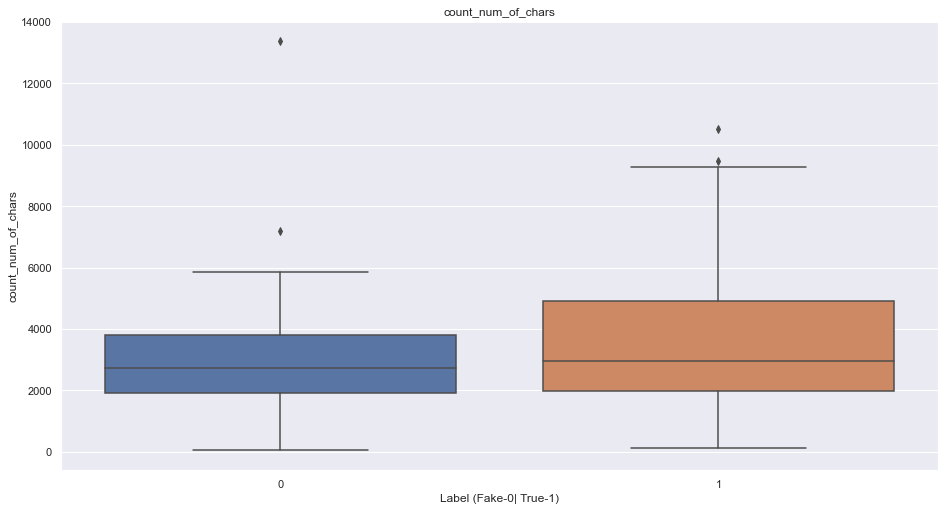

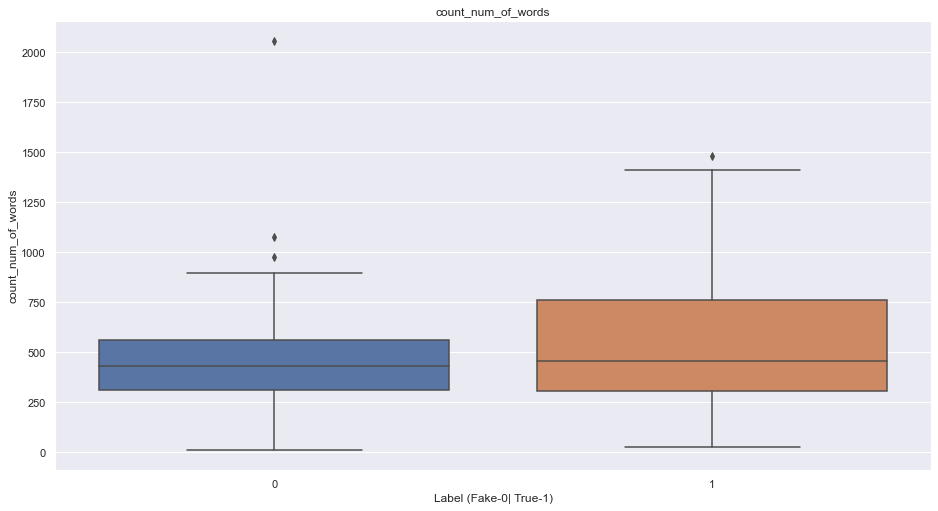

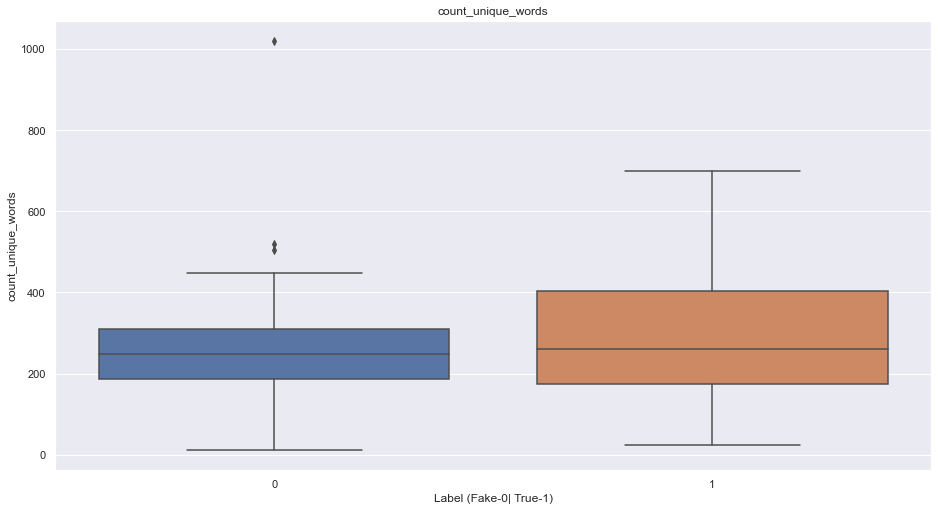

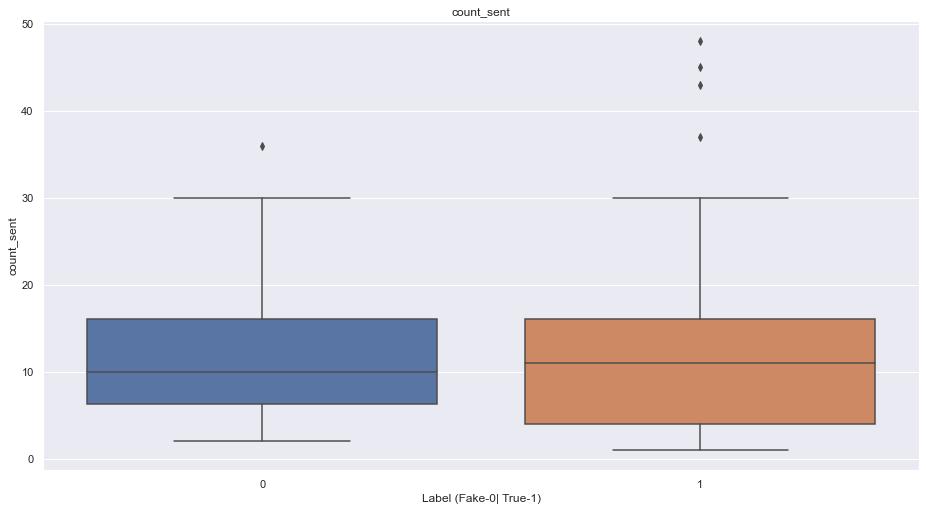

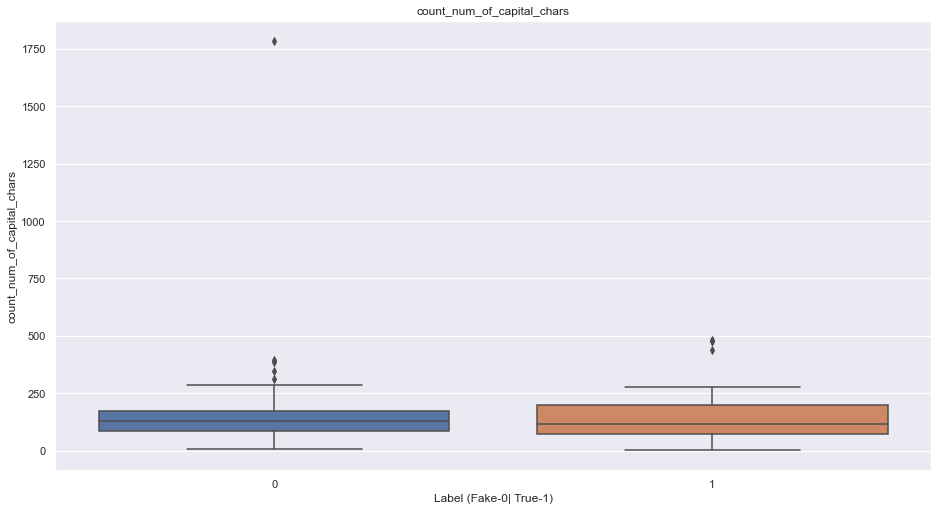

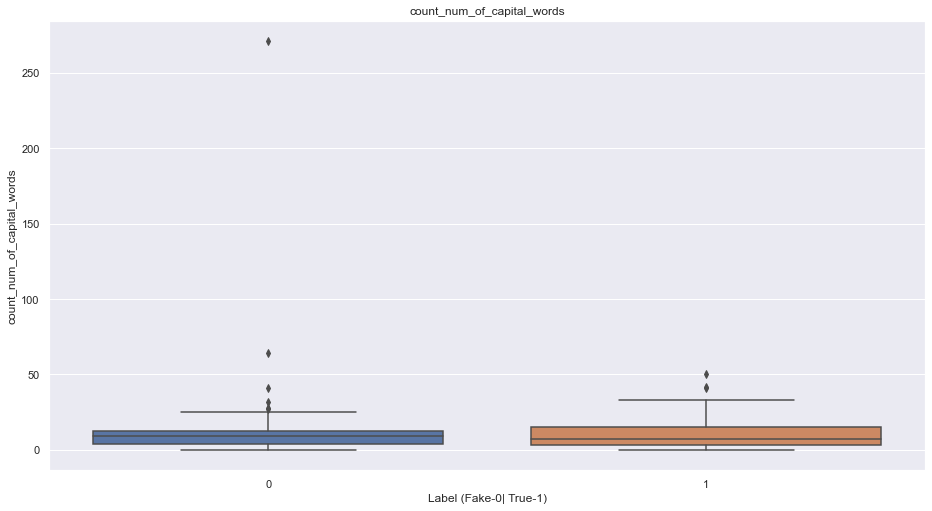

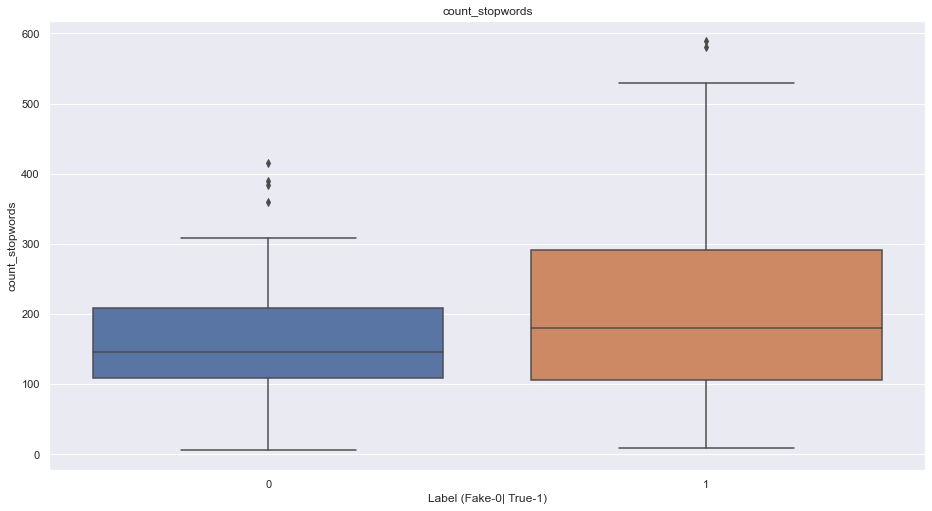

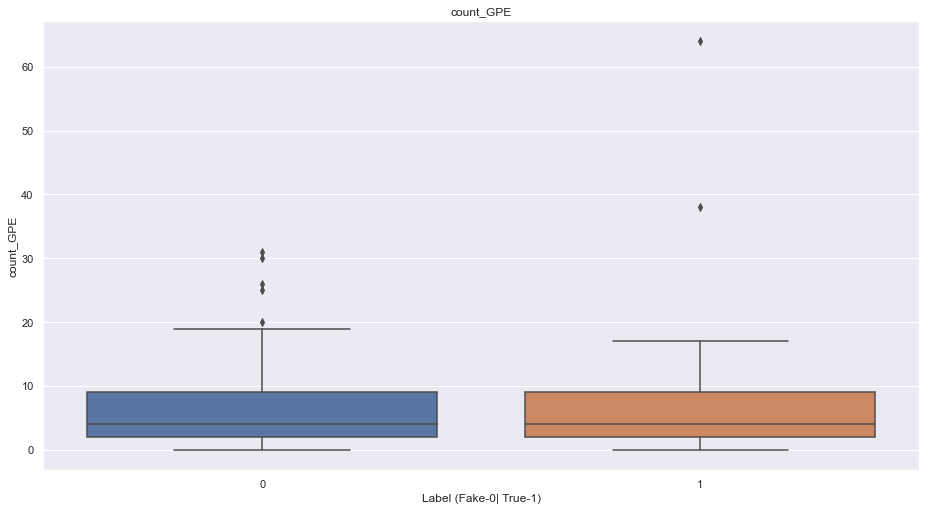

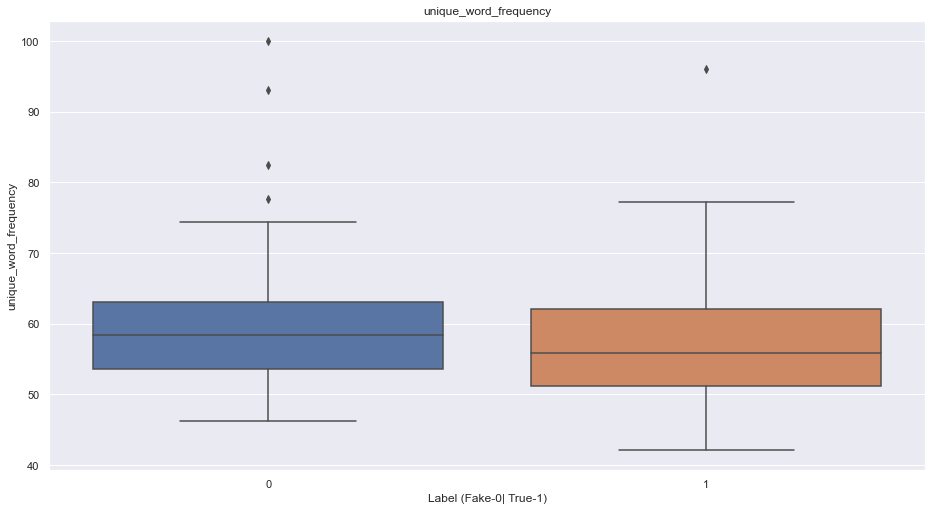

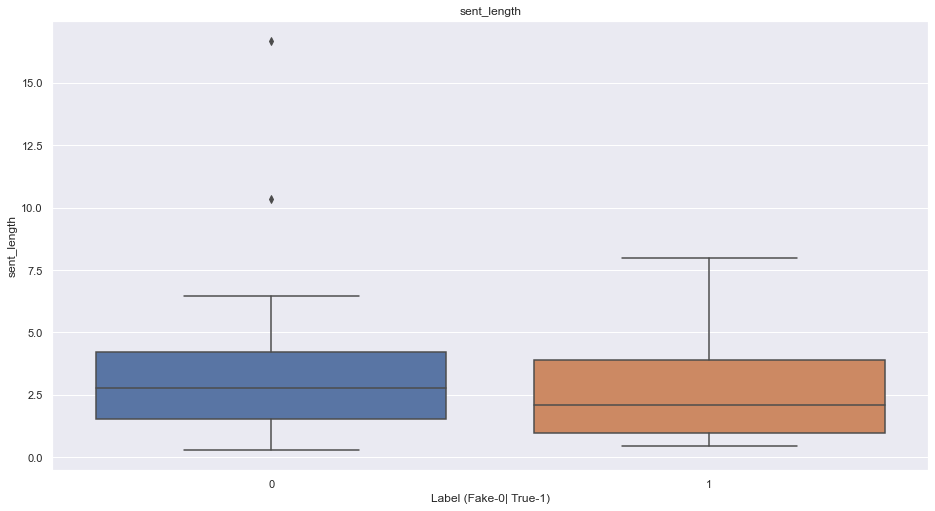

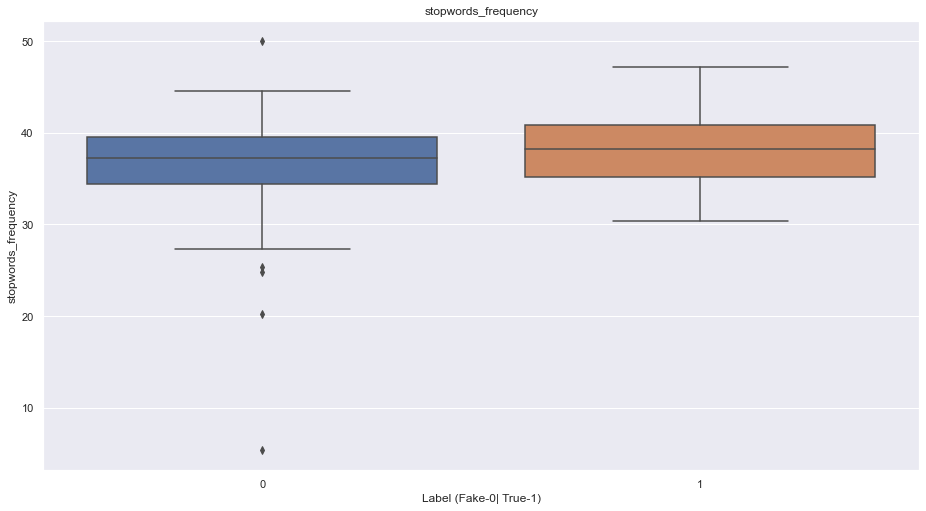

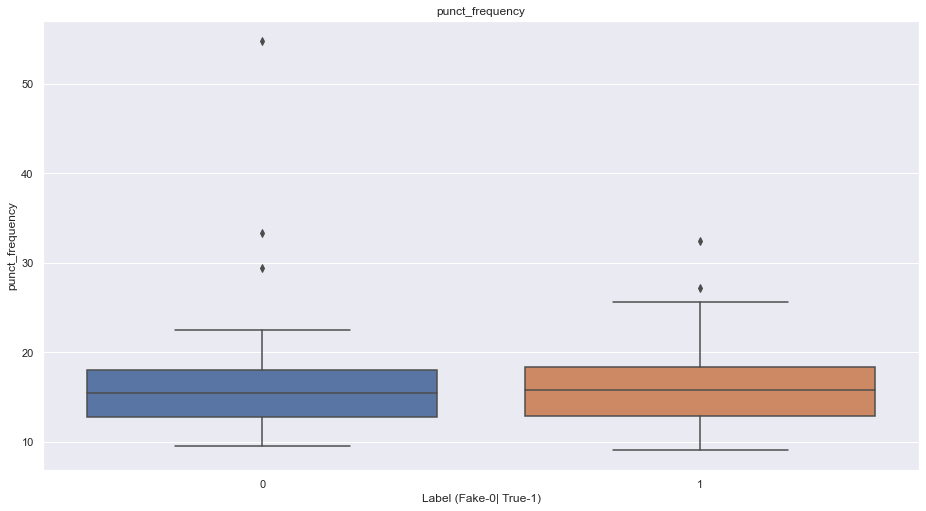

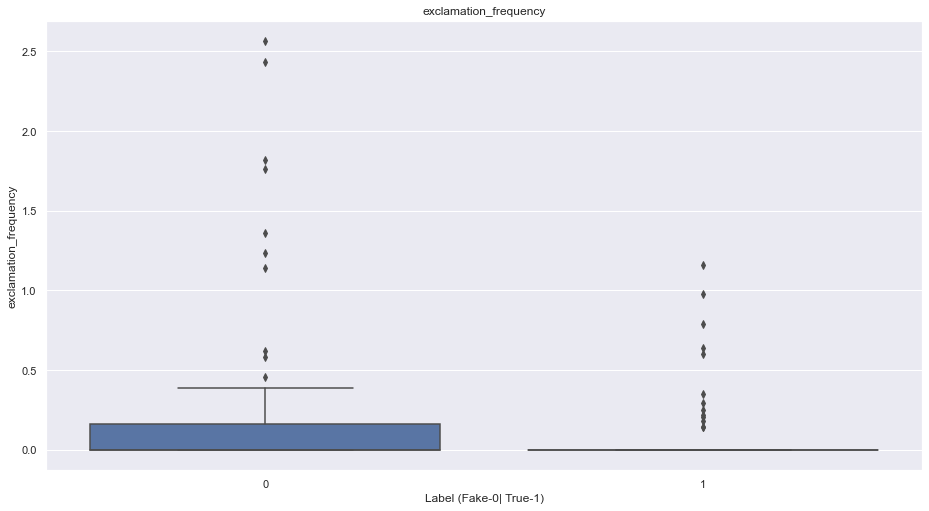

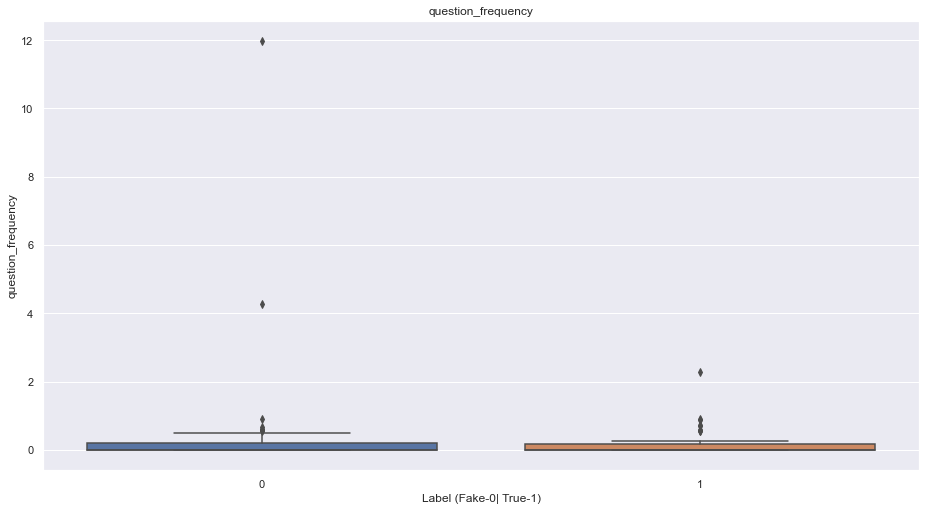

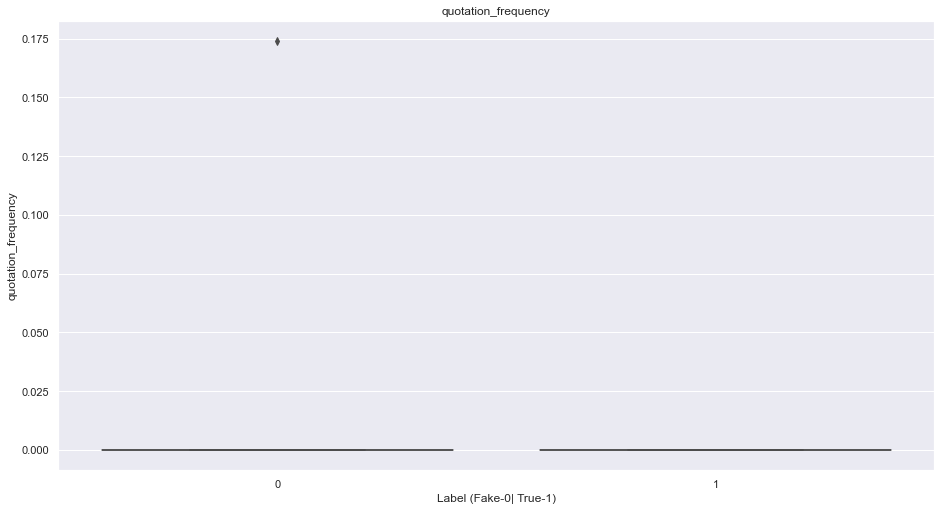

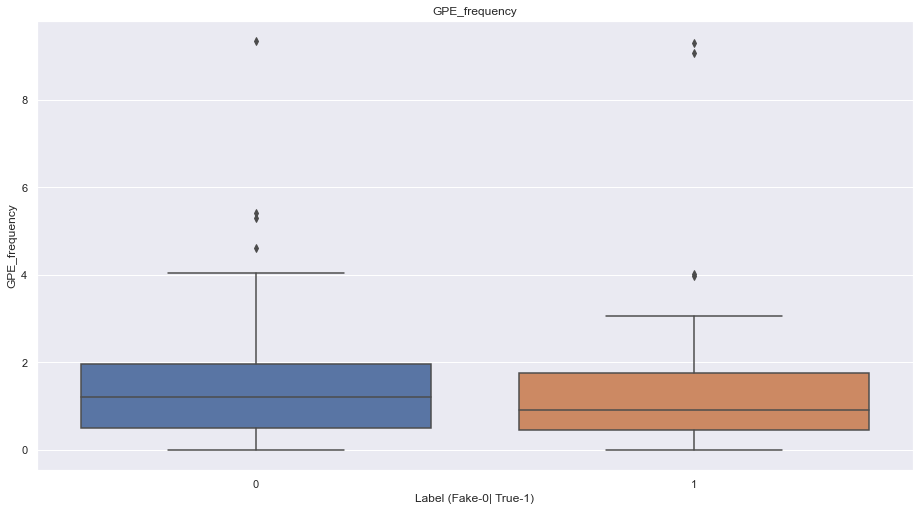

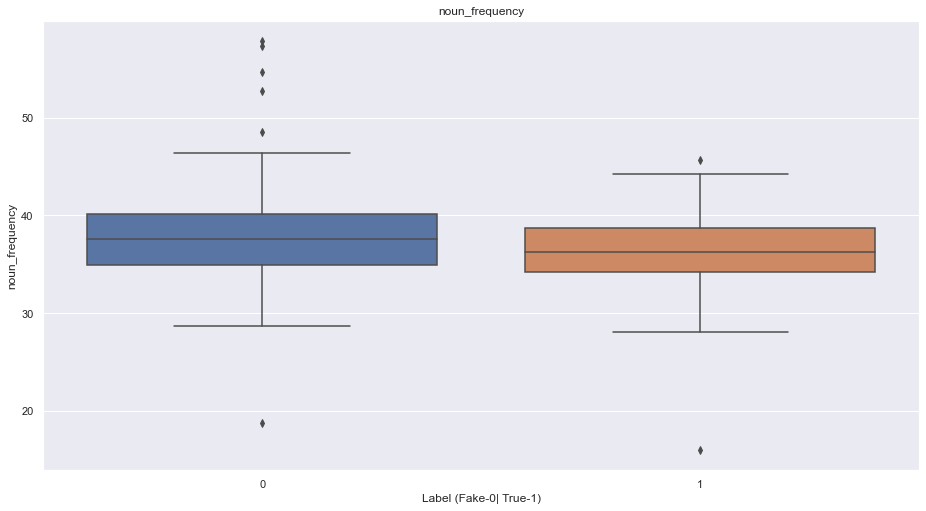

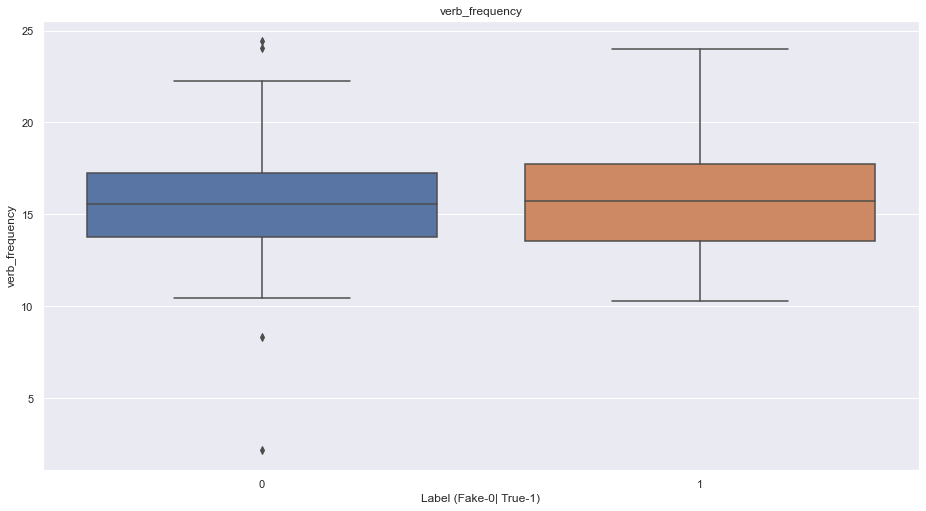

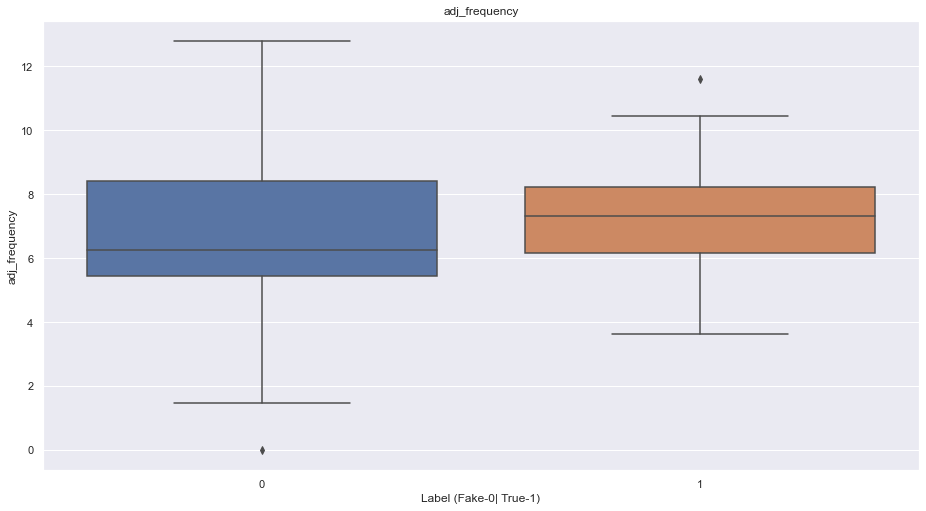

In [27]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
for col in box_plot_columns:
    sns.boxplot( x=df_feature_eng["Label (Fake-0| True-1)"], y=df_feature_eng[col]).set_title(col)
    plt.show()

### GPE Names

In [28]:
gpe_group = df_feature_eng.groupby('Label (Fake-0| True-1)')['GPE'].sum()

In [29]:
Counter(gpe_group[1])

Counter({'Liberia': 125,
         'Algeria': 2,
         'Guyana': 1,
         'Republic of Korea': 1,
         'Sierra Leone': 1,
         'Slovenia': 1,
         'China': 1,
         'France': 2,
         'Russia': 3,
         'the United Kingdom': 1,
         'the United States': 10,
         'Costaâ\x80\x99s': 1,
         'Montserrado County': 6,
         'United States': 2,
         'Monrovia': 11,
         'Montserrado': 2,
         'Liberia;And': 1,
         'Grand Bassa County': 4,
         'Grand Bassa County Superintendent': 1,
         'Garway': 1,
         'Grand Bassa': 2,
         'Sup': 1,
         'South Africa': 4,
         'Texas': 1,
         'West Africa': 5,
         'Bomi': 1,
         'Gbarpolu': 1,
         'Grand Kru': 3,
         'Lofa': 1,
         'Maryland': 4,
         'Nimba': 3,
         'Mass Communication.#ShineLiberiaThe': 1,
         'Uganda': 4,
         'Mengo': 1,
         'Facebookpost': 1,
         'Masooli': 1,
         'Nangabo Sub-County': 1,

In [32]:
Counter(gpe_group[0])

Counter({'Costa': 1,
         'Nimba County': 14,
         'Koung': 3,
         'Nimba': 2,
         'Nimledy': 1,
         'https://bit.ly/3NBpVNz': 1,
         'Liberia': 169,
         'Montserrado County': 10,
         'Logan': 2,
         'the Republic of Liberia': 3,
         'County': 1,
         'Monrovia': 17,
         'kpa-kpa-': 1,
         'Sanniquellie': 1,
         'US': 13,
         'becuh': 1,
         'Ireland': 2,
         'Ganta': 1,
         'the County': 1,
         'Montserrado': 4,
         'District 2': 1,
         'Buchanan': 2,
         'Grand Bassa County': 3,
         'Cambridge': 1,
         'Jefferson Koijee': 1,
         'Bassa County': 1,
         'United States': 1,
         'Washington D.C.': 1,
         'ð\x9f\x8e\x89': 1,
         'Portsmouth': 1,
         'United Kingdom': 2,
         'Washing D.C.': 1,
         'Washington DC': 3,
         'USA': 1,
         'Ethiopia': 2,
         'Madagascar': 1,
         'Senegal': 1,
         'Nigeria': 9,
     

### Model (Random Forest)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_feature_eng[box_plot_columns], 
                                                    df_feature_eng['Label (Fake-0| True-1)'], 
                                                    test_size=0.2,
                                                    stratify=df_feature_eng['Label (Fake-0| True-1)'],
                                                   )

In [94]:
clf_model = RandomForestClassifier(n_estimators = 500)

In [ ]:
clf_model.fit(X_train, y_train)
y_pred = clf_model.predict(X_test)

In [92]:
confusion_matrix(y_test, y_pred)

array([[13,  2],
       [ 7,  5]], dtype=int64)

In [80]:
df_importance = pd.DataFrame(zip(X_train.columns, clf_model.feature_importances_),
                             columns=['feature', 'importance'
                                     ]).sort_values('importance', ascending=False)

[Text(0, 0, '0.08'),
 Text(0, 0, '0.08'),
 Text(0, 0, '0.07'),
 Text(0, 0, '0.07'),
 Text(0, 0, '0.07'),
 Text(0, 0, '0.07'),
 Text(0, 0, '0.06'),
 Text(0, 0, '0.06'),
 Text(0, 0, '0.06'),
 Text(0, 0, '0.06'),
 Text(0, 0, '0.06'),
 Text(0, 0, '0.05'),
 Text(0, 0, '0.05'),
 Text(0, 0, '0.05'),
 Text(0, 0, '0.04')]

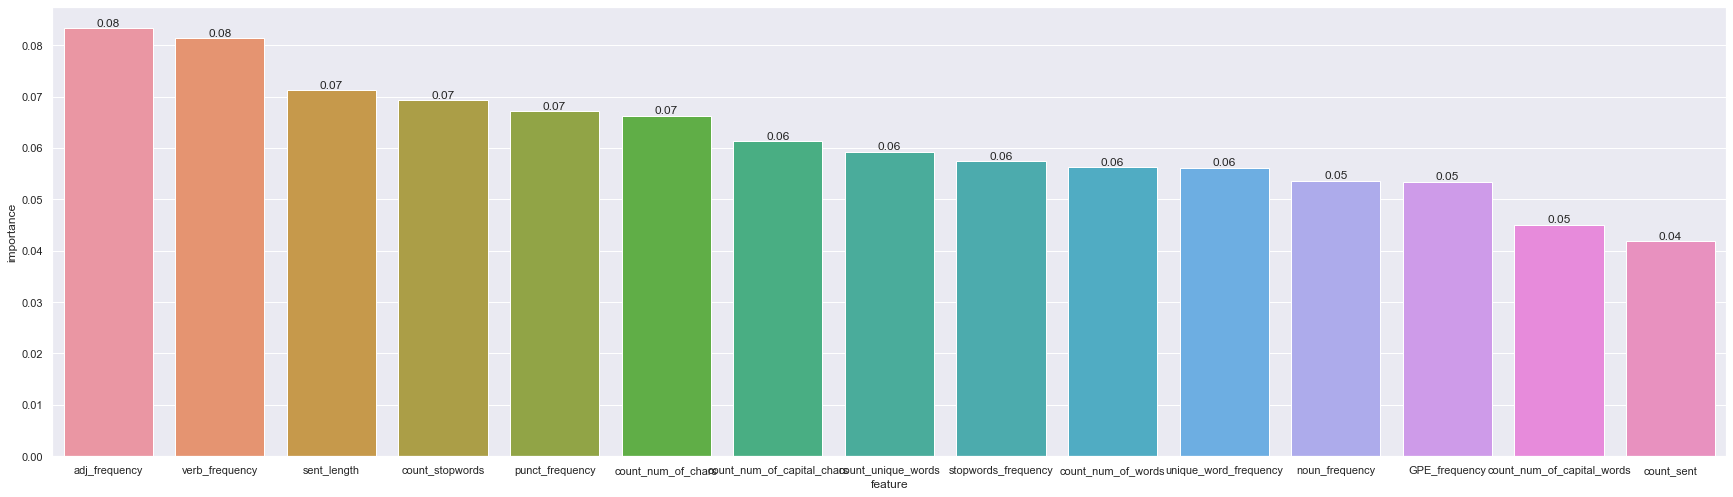

In [81]:
sns.set(rc={'figure.figsize':(30,8.27)})
ax = sns.barplot(x='feature', y='importance', data=df_importance[:15])
ax.bar_label(ax.containers[0], fmt='%.2f')

## TF-IDF

In [ ]:
pd.set_option('display.max_columns', 10)

### processing

In [ ]:
#remove not ascii
def delete_not_ascii(text):
    text = re.sub(r'[^\x00-\x7f]', '', text)
    return text 

#remove urls
def remove_urls(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

#remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r' NUMBER ', text)

#remove punctuation
def remove_punct(text):
    text = re.sub('[' + string.punctuation +']', ' ', text)
    return text     

# remove line breaks and extra spaces
def clean_text(text):
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

def convert_lower_case(text):
    return text.lower()

#contractions and remowing stopwords and very short words
def string_contractions(text):
    string_wothout_contractions = ''
    expanded_words = []  
    for each_word in text.split():
        if each_word not in (STOPWORDS):
            if len(each_word) >= 3:
                expanded_words.append(contractions.fix(each_word))
    string_wothout_contractions = ' '.join(expanded_words)
    return string_wothout_contractions

In [ ]:
def basic_cleaning(df, column_name):
    #df = copy.deepcopy(df_in)
    df[column_name] = df[column_name].apply(delete_not_ascii)
    df[column_name] = df[column_name].apply(remove_urls)
    df[column_name] = df[column_name].apply(remove_number)
    df[column_name] = df[column_name].apply(convert_lower_case)
    df[column_name] = df[column_name].apply(string_contractions)
    df[column_name] = df[column_name].apply(remove_punct)
    df[column_name] = df[column_name].apply(clean_text)
    #return df

In [ ]:
## .loc will create a new copy, not view
df_clean = df.loc[:, ('text_before_conclusion', 'Label (Fake-0| True-1)')]
basic_cleaning(df_clean, 'text_before_conclusion')

In [ ]:
df_clean

### Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_clean.text_before_conclusion, 
                                                    df_clean['Label (Fake-0| True-1)'], 
                                                    test_size=0.2,
                                                    stratify=df_clean['Label (Fake-0| True-1)'])

In [ ]:
df_clean['Label (Fake-0| True-1)'].value_counts()/len(df_clean)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tf_idf = vectorizer.fit_transform(X_train)
X_test_tf_idf = vectorizer.transform(X_test)


df_X_train_tf_idf = pd.DataFrame(X_train_tf_idf.toarray(), columns=vectorizer.get_feature_names_out())
df_X_test_tf_idf = pd.DataFrame(X_test_tf_idf.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
df_X_train_tf_idf

In [ ]:
clf_model = RandomForestClassifier(n_estimators = 500)

In [ ]:
clf_model.fit(df_X_train_tf_idf, y_train)

In [ ]:
y_pred = clf_model.predict(df_X_test_tf_idf)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
sum(y_test)